In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
import matplotlib.pyplot as plt
import os

In [21]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
dataset_dir = "../data/balanced_dataset"  # your dataset
image_size = 224  
batch_size = 16
epochs = 10


In [23]:
# Load all images
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    seed=42,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

class_names = dataset.class_names
print("Classes:", class_names)


Found 17596 files belonging to 47 classes.
Classes: ['African Violet (Saintpaulia ionantha)', 'Aloe Vera', 'Anthurium (Anthurium andraeanum)', 'Areca Palm (Dypsis lutescens)', 'Asparagus Fern (Asparagus setaceus)', 'Begonia (Begonia spp.)', 'Bird of Paradise (Strelitzia reginae)', 'Birds Nest Fern (Asplenium nidus)', 'Boston Fern (Nephrolepis exaltata)', 'Calathea', 'Cast Iron Plant (Aspidistra elatior)', 'Chinese Money Plant (Pilea peperomioides)', 'Chinese evergreen (Aglaonema)', 'Christmas Cactus (Schlumbergera bridgesii)', 'Chrysanthemum', 'Ctenanthe', 'Daffodils (Narcissus spp.)', 'Dracaena', 'Dumb Cane (Dieffenbachia spp.)', 'Elephant Ear (Alocasia spp.)', 'English Ivy (Hedera helix)', 'Hyacinth (Hyacinthus orientalis)', 'Iron Cross begonia (Begonia masoniana)', 'Jade plant (Crassula ovata)', 'Kalanchoe', 'Lilium (Hemerocallis)', 'Lily of the valley (Convallaria majalis)', 'Money Tree (Pachira aquatica)', 'Monstera Deliciosa (Monstera deliciosa)', 'Orchid', 'Parlor Palm (Chamaedo

In [24]:
def get_dataset_partitions(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=42)
    
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [26]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [28]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=(image_size, image_size, 3)),
    resize_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [29]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)     

In [30]:
epochs = 30
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/30
880/880 [==============================] - 221s 172ms/step - loss: 3.6566 - accuracy: 0.0740 - val_loss: 3.3079 - val_accuracy: 0.1420
Epoch 2/30
880/880 [==============================] - 233s 189ms/step - loss: 3.2463 - accuracy: 0.1499 - val_loss: 3.2383 - val_accuracy: 0.1714
Epoch 3/30
880/880 [==============================] - 234s 189ms/step - loss: 3.0042 - accuracy: 0.2197 - val_loss: 2.8378 - val_accuracy: 0.2602
Epoch 4/30
880/880 [==============================] - 232s 187ms/step - loss: 2.8454 - accuracy: 0.2623 - val_loss: 2.6731 - val_accuracy: 0.3011
Epoch 5/30
880/880 [==============================] - 233s 187ms/step - loss: 2.7034 - accuracy: 0.2989 - val_loss: 3.6038 - val_accuracy: 0.2000
Epoch 6/30
880/880 [==============================] - 234s 189ms/step - loss: 2.5882 - accuracy: 0.3322 - val_loss: 2.9687 - val_accuracy: 0.2841
Epoch 7/30
880/880 [==============================] - 234s 191ms/step - loss: 2.5311 - accuracy: 0.3532 - val_loss: 2.3818 -

In [31]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


110/110 [==============================] - 68s 16ms/step - loss: 1.6531 - accuracy: 0.5955
Test Accuracy: 0.5954545736312866


In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

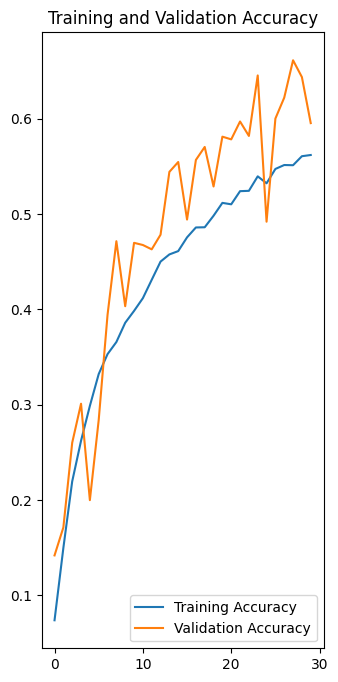

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

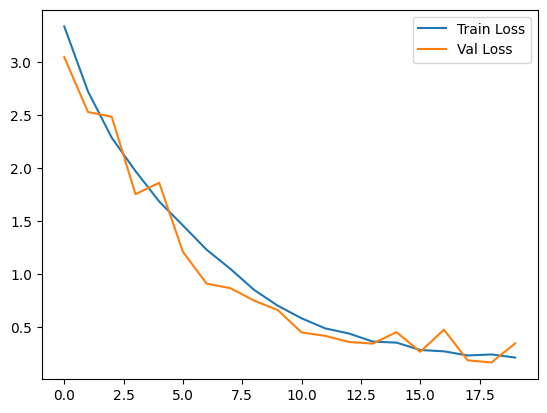

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

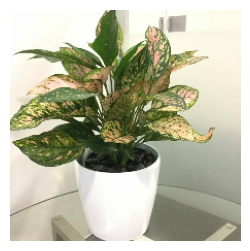

Actual Label: Chinese evergreen (Aglaonema)
1/1 [==============================] - 0s 170ms/step
Predicted Label: Chinese evergreen (Aglaonema)


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the test dataset
plt.figure(figsize=(3, 3))
for images_batch, labels_batch in test_ds.take(1):
    
    # Get the first image and label
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    # Display the image
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    # Print the actual label
    print("Actual Label:", class_names[first_label])
    
    # Predict using the model
    batch_prediction = model.predict(images_batch)
    predicted_index = np.argmax(batch_prediction[0])
    print("Predicted Label:", class_names[predicted_index])

In [35]:
model.save("plant_species_classifier_2.h5")


In [36]:
import os

model_dir = "../models"
existing_versions = [
    int(f.split(".")[0])  # split '1.keras' to get '1', then convert to int
    for f in os.listdir(model_dir)
    if f.endswith(".keras") and f.split(".")[0].isdigit()
]

model_version = max(existing_versions + [0]) + 1
model.save(f"{model_dir}/{model_version}.keras")

In [19]:
# index -> class name mapping
class_indices = {i: name for i, name in enumerate(class_names)}

print(class_indices)


{0: 'African Violet (Saintpaulia ionantha)', 1: 'Aloe Vera', 2: 'Anthurium (Anthurium andraeanum)', 3: 'Areca Palm (Dypsis lutescens)', 4: 'Asparagus Fern (Asparagus setaceus)', 5: 'Begonia (Begonia spp.)', 6: 'Bird of Paradise (Strelitzia reginae)', 7: 'Birds Nest Fern (Asplenium nidus)', 8: 'Boston Fern (Nephrolepis exaltata)', 9: 'Calathea', 10: 'Cast Iron Plant (Aspidistra elatior)', 11: 'Chinese Money Plant (Pilea peperomioides)', 12: 'Chinese evergreen (Aglaonema)', 13: 'Christmas Cactus (Schlumbergera bridgesii)', 14: 'Chrysanthemum', 15: 'Ctenanthe', 16: 'Daffodils (Narcissus spp.)', 17: 'Dracaena', 18: 'Dumb Cane (Dieffenbachia spp.)', 19: 'Elephant Ear (Alocasia spp.)', 20: 'English Ivy (Hedera helix)', 21: 'Hyacinth (Hyacinthus orientalis)', 22: 'Iron Cross begonia (Begonia masoniana)', 23: 'Jade plant (Crassula ovata)', 24: 'Kalanchoe', 25: 'Lilium (Hemerocallis)', 26: 'Lily of the valley (Convallaria majalis)', 27: 'Money Tree (Pachira aquatica)', 28: 'Monstera Deliciosa (